$$
\newcommand{\pd}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bx}[2]{\mathbf{x}_{#1}^{\mathrm{#2}}}
\newcommand{\by}[2]{\mathbf{y}_{#1}^{\mathrm{#2}}}
\newcommand{\bw}[2]{\mathbf{w}_{#1}^{\mathrm{#2}}}
\newcommand{\dbp}[2]{\delta\mathbf{p}_{#1}^{\mathrm{#2}}}
$$
## Lorenzモデル

Lorenz (1963)のモデル（以下Lorenz-63）は熱対流を理想化したモデルで，パラメタ次第でカオスにふるまいます。Lorenz-63は次の3変数の常微分方程式で表されます。

$$
\begin{align}
\dot{X} &= -\sigma X + \sigma Y \\
\dot{Y} &= -XZ + rX -Y \\ \label{l63}\tag{1}
\dot{Z} &= XY - \beta Z
\end{align}
$$

パラメタ$\sigma$, $r$, $\beta$ はそれぞれPrandtl数，変形されたRayleigh数，アスペクト比を表しています。
予報変数$X, Y, Z$はそれぞれ無次元化された対流の強さ，最大温度差，対流に伴う成層の変化を表すものです。
左辺の変数の上の$\cdot$は時間微分$\mathrm{d}/\mathrm{d}t$を表す記号です。

　Lorenz-63を使って，まず変分法を用いて観測を同化して最適な初期値を求めてみましょう。次にニューラルネットワークを使って教師データからモデルを推定します。


### 変分法

変分法データ同化は，観測を用いてより良い初期状態を修正する手法です。
初期値の推定精度の指標となるスカラー函数を評価函数またはコスト函数と呼び，$J$で表します。
評価函数が最小になる推定値が最適な初期値です。
最適な初期値を推定するためには，初期値に摂動を与えたときに評価函数がどれくらい変化するかという情報，つまり初期値に対する評価函数の勾配$\nabla J$が必要です。
勾配が求まれば，$\nabla J=0$を数値最適化手法を用いて求めることが可能です。

ここでは簡単のため予報される場所で観測も行われるものとし，評価函数は予報の観測からの乖離
$$
J = \frac{1}{2}\sum_{k=0}^{n}(\bx{k}{f}-\by{k}{o})^T(\bx{k}{f}-\by{k}{o})\label{cost}\tag{2}
$$
で表すことにします。
$\bx{k}{f}, \by{k}{o}$はそれぞれステップ$k$での予報$\mathrm{f}$と観測$\mathrm{o}$を表しています。
背景誤差共分散$\mathbf{B}$と観測誤差共分散$\mathbf{R}$が与えられた場合は
$$
J = \frac{1}{2}(\bx{0}{}-\bx{0}{f})^T\mathbf{B}^{-1}(\bx{0}{}-\bx{0}{f}) + \frac{1}{2}\sum_{k=0}^{n}(\by{k}{o}-\mathbf{H}\bx{k}{f})^T\mathbf{R}^{-1}(\by{k}{o}-\mathbf{H}\bx{k}{f})\label{costbr}\tag{3}
$$
を評価関数とすることもできます。

勾配を効率的に求めるために，随伴モデルが用いられます。
随伴モデルは，モデルを基本場の周りに線型化したモデル（接線型モデル）を行列で表したとき転置して得られるものです。
非線型のモデルを$\mathcal{M}$で表すと，ステップ$k-1$から$k$への時間発展は
$$
\bx{k}{f} = \mathcal{M}\left(\bx{k-1}{f}\right)　\label{nonlinear}\tag{4}
$$
と表すことができます。

摂動を与えた$\bx{k}{f} + \delta\bx{k}{f}$の時間発展から摂動なしの時間発展を引き，摂動の2次以上の項を無視すると摂動の時間発展
$$
\delta\bx{k}{f} = \pd{\mathcal{M}\left(\bx{k-1}{f}\right)}{\bx{k-1}{f}}\delta\bx{k-1}{f} = \mathbf{L}\left(\bx{k-1}{f}\right)\delta\bx{k-1}{f} \label{TLM}\tag{5}
$$
が得られます。
$\mathbf{L}$は接線型モデルを表す線型演算子です。

接線型演算子を繰り返し用いることにより $\delta\bx{k}{f}$ と$\delta\bx{0}{f}$の関係を次のように表すことができます。
$$
\delta\bx{k}{f} = \mathbf{L}\left(\bx{k-1}{f}\right)\mathbf{L}\left(\bx{k-2}{f}\right)\cdots\mathbf{L}\left(\bx{0}{f}\right)\delta\bx{0}{f} = \mathbf{L}_k\delta\bx{0}{f} \label{Lk}\tag{6}
$$

一方，評価函数(\ref{cost})の勾配は
$$
\left[\nabla J(\bx{0}{f})\right]^T\delta\bx{0}{f} = \sum_k(\bx{k}{f}-\by{k}{o})^T\delta\bx{k}{f} \label{grad}\tag{7}
$$
と表すことができるので，勾配は
$$
\nabla J(\bx{0}{f}) = \sum_k\mathbf{L}_k^T\left(\bx{k}{f}-\bx{k}{o}\right) \label{nablaJ}\tag{8}
$$
から求めることができます。

ここで接線型演算子の転置
$$
\mathbf{L}_k^T = \mathbf{L}^T\left(\bx{0}{f}\right)\mathbf{L}^T\left(\bx{1}{f}\right)\cdots\mathbf{L}^T\left(\bx{k-2}{f}\right)\mathbf{L}^T\left(\bx{k-1}{f}\right) \label{LT}\tag{9}
$$
は随伴モデルを表す演算子です。

(\ref{nablaJ})は観測からの乖離に随伴演算子を作用させながら，時間逆方向に$0$まで和を取ることにより得られることを示しています。

変分法によるデータ同化の手順は次の通りです。
観測を同化される期間を同化ウィンドウ（同化窓）あるいは単にウィンドウといいます。

1. 非線型モデルを実行し，途中の結果を保存しておく。
2. 同化ウィンドウの終わりから初期時刻に向かって随伴モデルを積分し勾配を計算する。
3. 勾配を用いて数値最適化を行い，初期値を更新する。
4. 勾配が閾値を下回るか，最大の繰り返し回数を超えたら終了。そうでなけれぱ1に戻る。


### Pythonコード

Lorenz-63の非線型モデル，接線型モデル，随伴モデルをPythonで書いてみましょう。
Prandtl数，Rayleigh数，アスペクト比はそれぞれ`p`, `r`, `b`で表されています。
`x, y, z = w`のように1次元配列を展開して式との対応がつきやすいように工夫しています。
わずかに異なる初期値から積分してみると，一方はアトラクタと呼ばれる点の周りを周回しているのに対し，もう一方は別のアトラクタの周りに動いていったことが分かります。

In [1]:
def florenz(w, p, r, b):
    x, y, z = w
    dw = np.zeros_like(w)
    dw[0] =      -p * x + p * y 
    dw[1] = (r - z) * x -     y 
    dw[2] =           x * y     - b * z
    return dw

In [2]:
import numpy as np


p, r, b, dt = 10, 32, 8/3, 0.01
nstop = 500

w1 = np.zeros([nstop+1, 3])
w2 = np.zeros([nstop+1, 3])
w1[0, :] = 1, 3, 5
w2[0, :] = 1.1, 3.3, 5.5
for i in range(nstop):
    w1[i+1, :] = w1[i, :] + dt * florenz(w1[i, :], p, r, b)
    w2[i+1, :] = w2[i, :] + dt * florenz(w2[i, :], p, r, b)    

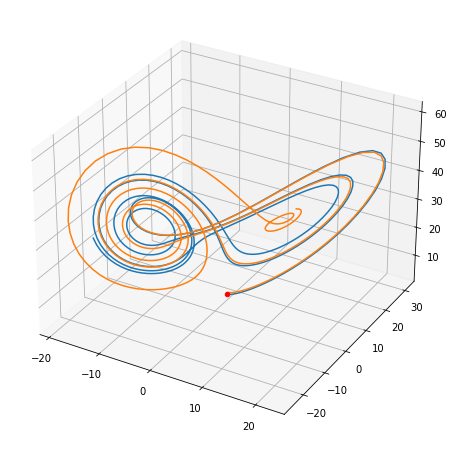

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(projection="3d")
ax.scatter(*w1[0, :], c="red")
ax.plot(*w1.transpose())
ax.plot(*w2.transpose())

3つの変数を少しずらして描画してみます。

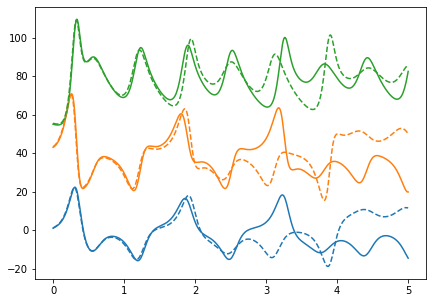

In [4]:
import matplotlib.pyplot as plt

off1, off2 = 40, 50

x = np.linspace(0, dt*nstop, nstop+1)
w = np.copy(w1)
w[:, 1] += off1
w[:, 2] += off2
fig, ax = plt.subplots(figsize=[7,5])
ax.plot(x, w)
plt.gca().set_prop_cycle(None)
w = np.copy(w2)
w[:, 1] += off1
w[:, 2] += off2
ax.plot(x, w, linestyle="--")

接線型モデルは非線型項を線型化して求めます。
二つの変数の積，例えば$\dot{Z}$の式の$XY$は$\delta XY+X\delta Y$のように二つの項に分かれます。
上述の手順では接線型モデルは使いませんが，接線型モデルを使う定式化もあります。

In [5]:
def tlorenz(wt, wb, p, r, b):
    dw = np.zeros_like(wt)
    xt, yt, zt = wt
    xb, yb, zb = wb
    dw[0] =       -p * xt +  p * yt 
    dw[1] = (r - zb) * xt -      yt - xb * zt
    dw[2] =       yb * xt + xb * yt -  b * zt
    return dw

随伴モデルは接線型モデルの転置として表されます。
随伴モデルの変数は0に初期化します。
随伴モデルを用いて積分を行うときは，各ステップで観測からの乖離を積算していきます。
随伴モデルの最後に時間変化は0にします。

In [6]:
def alorenz(wa, dwa, wb, p, r, b):
    xb, yb, zb = wb
    dxa, dya, dza = dwa
    wa[0] += -p * dxa + (r - zb) * dya + yb * dza
    wa[1] +=  p * dxa -            dya + xb * dza
    wa[2] +=          -       xb * dya -  b * dza
    dwa[:] = 0.0
    return wa, dwa

観測を真値に誤差を加えて作ります。観測の間隔は60ステップとします。誤差は正規分布に従い，標準偏差は初期値の10%とします。

In [7]:
p, r, b, dt = 10, 32, 8/3, 0.01
nstop = 200
obs_int = 60

rng = np.random.default_rng()
w = np.array([1.0, 3.0, 5.0])
e = w * 0.1
x_obs = np.zeros([nstop//obs_int, w.size])
x_obs[0, :] = w
x = np.zeros([nstop+1, w.size])
for i in range(1, nstop+1):
    w += dt * florenz(w, p, r, b)
    if i % obs_int == 0:
        x_obs[i//obs_int-1, :] = w + e * rng.standard_normal(w.size)
    x[i, :] = w
np.save("xt.npy", x)

随伴計算では改善した初期値から繰り返し予報をするので，予報と評価函数の計算をする関数を定義しておきます。

In [8]:
def run_florenz(w, xo, p, r, b):
    x = np.zeros([nstop+1, w.size])
    x[0, :] = w
    c = 0
    for i in range(1, nstop+1):
        w += dt * florenz(w, p, r, b)
        x[i, :] = w
        if i % obs_int == 0:
            c += ((w - xo[i//obs_int-1, :])**2).sum()
    c *= 0.5
    return x, c

最急降下法で同化を試みます。最大反復回数は100回，ステップ幅$5\times 10^{-4}$とします。

In [9]:
niter = 100
alpha = 5e-4

ad = np.zeros(w.size)
dad = np.zeros(w.size)
cost = np.zeros([niter])
cycles = [1, 2, 3, 5, 10, 30]

w = np.array([1.1, 3.3, 5.5])
x, cost[0] = run_florenz(w, x_obs, p, r, b)

for j in range(niter):
    ad[:] = 0.0
    for i in range(nstop, 0, -1):
        if i % obs_int == 0 and i > 0:
            ad += x[i, :] - x_obs[i//obs_int-1, :]
        dad += dt * ad
        ad, dad = alorenz(ad, dad, x[i, :], p, r, b)
    w = x[0, :] - alpha * ad
    x, cost[j] = run_florenz(w, x_obs, p, r, b)
    if j+1 in cycles:
        np.save(f"x{j+1:03}.npy", x)

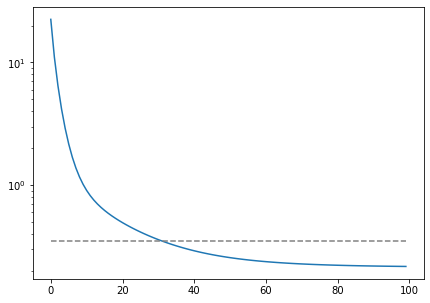

In [10]:
fig, ax = plt.subplots(figsize=[7, 5])
ax.semilogy(cost)
ax.plot([np.dot(e, e)]*cost.size, c="gray", linestyle="--")

最適化1, 2, 3, 5, 10, 30サイクルで真値（波線）に徐々に近づいていく様子を確認しましょう。

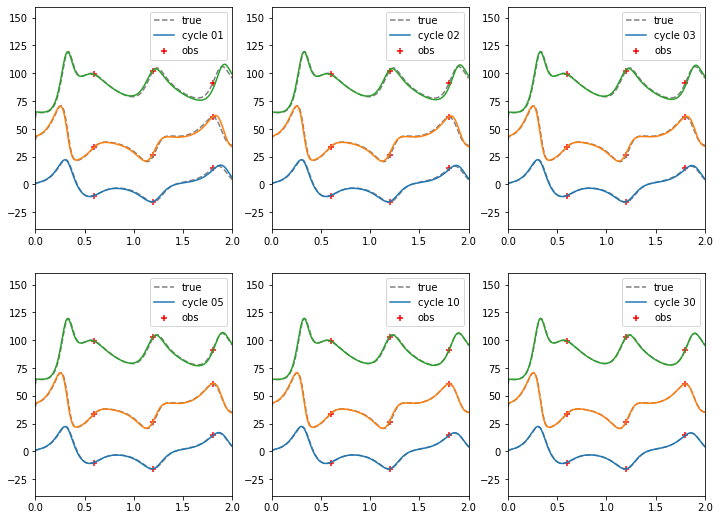

In [12]:
x = np.linspace(0, dt * nstop, nstop+1)
xobs = np.arange(obs_int, nstop, obs_int) * dt

nx, ny = 2, 3           
off1, off2 = 40, 60                              
fig, ax = plt.subplots(nx, ny, figsize=[12, 9])
wtrue = np.load("xt.npy")
wtrue[:, 1] += off1            
wtrue[:, 2] += off2
wobs = np.copy(x_obs)

wobs[:, 1] += off1
wobs[:, 2] += off2

k = 0
for ncyc in cycles:
    i, j = k // ny, k % ny
    k += 1
    w = np.load(f"x{ncyc:03}.npy")
    w[:, 1] += off1
    w[:, 2] += off2
    ax[i, j].plot(x, wtrue, c="gray", linestyle="--", label=["true","",""])
    ax[i, j].plot(x, w, label=[f"cycle {ncyc:02}","",""])
    ax[i, j].scatter(xobs, wobs[:,0], c="red", marker="+", label="obs")
    ax[i, j].scatter(xobs, wobs[:,1], c="red", marker="+")
    ax[i, j].scatter(xobs, wobs[:,2], c="red", marker="+")
    ax[i, j].set_xlim([0.0, 2.0])
    ax[i, j].set_ylim([-40, 160])
    ax[i, j].legend(loc="upper right")
    ax[i, j].set_prop_cycle(None)

### アンサンブルカルマンフィルタ

アンサンブルカルマンフィルタは変分法と並んで広く使われているデータ同化手法です。
変分法が最適制御理論に基づいているのに対し，アンサンブルカルマンフィルタは統計的推定論を理論的な背景としています。
統計的推定論からみたデータ同化の問題とは，事前に分かっている場の確率密度函数（pdf, probability distribution function）と観測のpdfから観測が得られたときの場の事後pdfを求めることです。
これらのpdf同士の関係はベイズの定理で表されます。

$$
P(\mathbf{x}|\mathbf{y}) = \frac{P(\mathbf{y}|\mathbf{x})P(\mathbf{x})}{P(\mathbf{y})}\label{bayes}\tag{10}
$$
$\mathbf{x}$を場の状態ベクトル，$\mathbf{y}$を観測としたとき，$P(\mathbf{x})$と$P(\mathbf{y})$はそれぞれ場，観測のpdfを表しています。
分母の$P(\mathbf{y})$は規格化を行っており，重要ではありません。
一方，$P(\mathbf{y}|\mathbf{x})$は場の状態$\mathbf{x}$を測定する場合のpdfで，$P(\mathbf{y}|\mathbf{x})\mathrm{d}\mathbf{y}$の積分は条件付き確率を表しています。
左辺の$P(\mathbf{x}|\mathbf{y})$は測定が行われ観測が与えられた条件の下での事後確率を表しています。
ベイズの定理は，場の状態が$\mathbf{x}$で観測が$\mathbf{y}$であるpdf
$$
P(\mathbf{x}, \mathbf{y}) = P(\mathbf{y}|\mathbf{x})P(\mathbf{x}) = P(\mathbf{x}|\mathbf{y})P(\mathbf{y})\nonumber
$$
から直ちに導出することができます。
ベイズの定理は，場の事前pdfを観測のpdfで更新することによって，観測が得られたときの事後確率を計算するものです。

状態と観測の確率密度が共にガウス型
$$
\begin{align}
P(\mathbf{x}) &\propto \exp\left[-\frac{1}{2}(\mathbf{x}-\mathbf{x}^\mathrm{f})^T\mathbf{P}_\mathrm{f}^{-1}(\mathbf{x}-\mathbf{x}^\mathrm{f})\right] \nonumber\\
P(\mathbf{y}|\mathbf{x}) &\propto \exp\left[-\frac{1}{2}(\mathbf{y}-\mathbf{Hx})^T\mathbf{R}^{-1}(\mathbf{y}-\mathbf{Hx})\right]\label{gaussian pdf}\tag{11}
\end{align}
$$
で表されると仮定します。
対数をとってベイズの定理(\ref{bayes})を適用すると
$$
-\ln P(\mathbf{x}|\mathbf{y}) = \frac{1}{2}(\mathbf{x}-\mathbf{x}^\mathrm{f})^T\mathbf{P}_\mathrm{f}^{-1}(\mathbf{x}-\mathbf{x}^\mathrm{f}) + \frac{1}{2}(\mathbf{y}-\mathbf{Hx})^T\mathbf{R}^{-1}(\mathbf{y}-\mathbf{Hx})\label{lnP}\tag{12}
$$
が得られます。
(\ref{lnP})は背景誤差共分散$\mathbf{B}$を予報誤差共分散$\mathbf{P}_\mathrm{f}$で近似した評価関数(3)にほかなりません。
最適推定値を$\mathbf{x}^\mathrm{a}$，解析誤差共分散を$\mathbf{P}_\mathrm{a}$とし，事後の確率密度にもガウス型を仮定すると
$$
-\ln P(\mathbf{x}|\mathbf{y}) = \frac{1}{2}(\mathbf{x}-\mathbf{x}^\mathrm{a})^T\mathbf{P}_\mathrm{a}^{-1}(\mathbf{x}-\mathbf{x}^\mathrm{a})\label{lnPa}\tag{13}
$$
(\ref{lnP})及び(\ref{lnPa})の$\mathbf{x}$の2次の項から
$$
\mathbf{P}_\mathrm{a}^{-1} = \mathbf{H}^T\mathbf{R}^{-1}\mathbf{H} + \mathbf{P}_\mathrm{f}^{-1}\label{Pa}\tag{14}
$$
$\mathbf{x}^T$の1次の項から
$$
\mathbf{x}^\mathrm{a} = \mathbf{x}^\mathrm{f} + \mathbf{K}(\mathbf{y}-\mathbf{H}\mathbf{x}^\mathrm{f})\label{xa}\tag{15}
$$
が得られます。
ここで
$$
\begin{align}
\mathbf{K} &= (\mathbf{H}^T\mathbf{R}\mathbf{H} + \mathbf{P}^\mathrm{f})^{-1}\mathbf{HR}^{-1} \label{n-form}\tag{16}\\
&= \mathbf{P}^\mathrm{f}\mathbf{H}^T(\mathbf{H}\mathbf{P}^\mathrm{f}\mathbf{H}^T + \mathbf{R})^{-1}\label{m-form}\tag{17}
\end{align}
$$
をカルマンゲインといいます。
(\ref{n-form})と(\ref{m-form})は逆行列をとる行列の次数がそれぞれ予報と観測誤差共分散行列の次数になっています。
サイズの小さい方を用いると効率よく計算できます。
(\ref{n-form})から(\ref{m-form})を導出するには
$$
\mathbf{H}^T\mathbf{R}^{-1}(\mathbf{R} + \mathbf{HP}_\mathrm{f}\mathbf{H}^T)=(\mathbf{P}_\mathrm{f}^{-1}+\mathbf{H}^T\mathbf{R}^{-1}\mathbf{H})\mathbf{P}_\mathrm{f}\mathbf{H}^T
$$
に前から$\mathbf{P}_\mathrm{f}^{-1}+\mathbf{H}^T\mathbf{R}^{-1}\mathbf{H})^{-1}$後ろから$(\mathbf{R}+\mathbf{HP}_\mathrm{f}\mathbf{H}^T)^{-1}$を作用させることにより求められます。

In [164]:
def po(xf, yo, rmat, hmat):
    dx = xf - np.mean(xf, axis=1)[:, None]
    pf = dx @ dx.transpose() / (nmem - 1)
    ic = hmat @ pf @ hmat.transpose() + rmat
    kmat = pf @ hmat.transpose() @ np.linalg.inv(ic)   
    xa = xf + kmat @ (yo - hmat @ xf)
    return xa

def run_ens(xf, p, r, b, nstop):
    _, nmem = xf.shape
    for i in range(nmem):
        w = xf[:, i]
        for k in range(nstop):
            w += dt * florenz(w, p, r, b)
        xf[:, i] = w           
    return xf

In [246]:
nmem = 3
xs = 3.0
nstop = 200
obs_int = 60

hmat = np.eye(w.size)
rmat = np.diag(e**2)

xtrue = np.load("xt.npy")
w = np.array([1, -3, 5])
rng = np.random.default_rng()
xf = np.zeros([w.size, nmem])
for i in range(w.size):
    xf[i, :] = w[i, None] + xs * rng.standard_normal(nmem)
np.save("xf000.npy", xf)
yo = np.zeros([w.size, nmem])
for j in range(nstop//obs_int):
    for i in range(w.size):
        yo[i, :] = xtrue[obs_int*(j+1), i] + e[i] * rng.standard_normal(nmem)
    xf = run_ens(xf, p, r, b, obs_int)
    np.save(f"xf{obs_int*(j+1):03}.npy", xf)
    xa = po(xf, yo, rmat, hmat)
    np.save(f"xa{obs_int*(j+1):03}.npy", xa)
    xf = xa

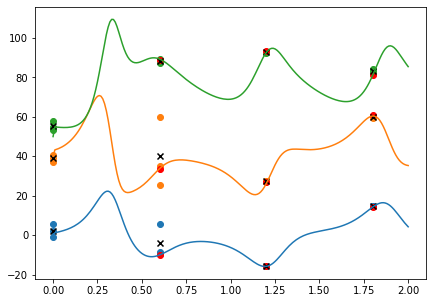

In [247]:
off = 0, 40, 50

x = np.linspace(0, dt*nstop, nstop+1)
wtrue = np.copy(xtrue)
wtrue[:, 1] += off1            
wtrue[:, 2] += off2
fig, ax = plt.subplots(figsize=[7, 5])
ax.plot(x, wtrue)
xf = np.load("xf000.npy")
xf_mean = np.mean(xf, axis=1)
ax.set_prop_cycle(None)
for i in range(len(off)):
    ax.scatter([0]*nmem, xf[i, :] + off[i])
for i in range(len(off)):
    ax.scatter(0, xf_mean[i] + off[i], c="black", marker="x")
for j in range(nstop//obs_int):
    ax.set_prop_cycle(None)
    xf = np.load(f"xf{obs_int*(j+1):03}.npy")
    xf_mean = np.mean(xf, axis=1)
    xa = np.load(f"xa{obs_int*(j+1):03}.npy")
    xa_mean = np.mean(xa, axis=1)
    t = obs_int*(j+1) * dt
    tnmem = [t] * nmem
    for i in range(len(off)):
        ax.scatter(tnmem, xf[i, :] + off[i])
    for i in range(len(off)):
        ax.scatter(t, xa_mean[i] + off[i], c="red")
    for i in range(len(off)):
        ax.scatter(t, xf_mean[i] + off[i], c="black", marker="x")

### ニューラルネットワーク